In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 258 kB 4.0 MB/s 
     |████████████████████████████████| 1.8 MB 68.8 MB/s 
     |████████████████████████████████| 103 kB 69.7 MB/s 


In [3]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [4]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [5]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    n_geographic_split = 48
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [6]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [7]:
%load_ext Cython

In [8]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [9]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by latlon_section')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [10]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    
    df['kdist_diff'] = (df['kdist'] - df['kdist_country']) /\
                                df['kdist_country']
    df['kneighbors_mean'] = df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return df

In [11]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [12]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [13]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


#Add new geographic coordinate classification

In [14]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [15]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [16]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0,570
1,E_00009ab517afac,Starbucks,26.305220,50.129444,Ibis Avenue,Dhahran,Ash Sharqiyah,34465,SA,NaN,NaN,Coffee Shops,P_6bef315eab584f,1.0,728
2,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,NaN,"Cafés, Coffee Shops",P_c9997611c608a1,1.0,955
3,E_0000c566a81ea1,つじ田 味噌の章,35.694796,139.767348,神田小川町1-1,千代田区,東京都,101-0052,JP,https://tsukemen-tsujita.com,366597676,Ramen Restaurants,P_5fcd8cd98fea2b,1.0,1005
4,E_0000d9e584ed9f,Signature Properties Savannah,32.012582,-81.113156,100 Commercial Ct Ste C,Savannah,GA,31406,US,http://www.oursignatureproperties.com,9126292700,Real Estate Offices,P_af856e3abdcebc,1.0,314


<BarContainer object of 370 artists>

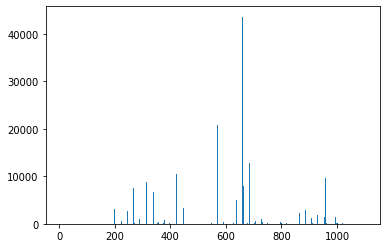

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

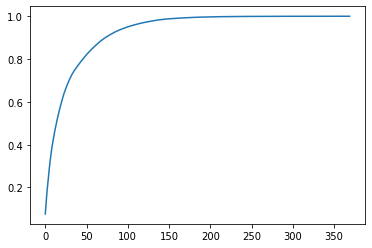

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data, CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by latlon_section


  0%|          | 0/370 [00:00<?, ?it/s]

Start knn
Num of unique id: 569406
Num of train data: 13273546
Pos rate: 0.0760047842528289
                        id          match_id     kdist  kneighbors  \
12835894  E_bba2cee1fe82e6  E_a632fe9fe99476       NaN         NaN   
3649966   E_68cbd28fb2dec8  E_65e4e9253bbbe2  0.002972         6.0   
4233317   E_6f2251639017a9  E_40b9c384871120  0.009543         7.0   
6358495   E_2aa08e50638a42  E_c14f0e3b75cd71  0.005964        11.0   
2791976   E_e72d1d671cf3f2  E_fcb5f5de269e2d  0.001256         4.0   

          kdist_country  kneighbors_country  label  
12835894       0.004305                17.0      0  
3649966        0.002844                 8.0      0  
4233317        0.009414                 7.0      0  
6358495        0.005512                14.0      0  
2791976        0.001029                 2.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 569406
Unique id: 569406
IoU score: 0.923328913265504


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.40%,7.60%
development set - fold 0,92.40%,7.60%
validation set - fold 0,92.40%,7.60%
development set - fold 1,92.40%,7.60%
validation set - fold 1,92.40%,7.60%
development set - fold 2,92.40%,7.60%
validation set - fold 2,92.40%,7.60%
development set - fold 3,92.40%,7.60%
validation set - fold 3,92.40%,7.60%
development set - fold 4,92.40%,7.60%


In [ ]:
data = data.set_index('id')

# model learning

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        
        print(f"== fold {i} ==")
        trn_idx = folds==((i - 1) % CFG.num_split)
        val_idx = folds==i
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        
        X_train = add_features(X_train)
        X_valid = add_features(X_valid)
        X_train = X_train[features]
        X_valid = X_valid[features]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

        del X_train, X_valid
        gc.collect()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0466171
[100]	valid_0's binary_logloss: 0.0452917
[150]	valid_0's binary_logloss: 0.044687
[200]	valid_0's binary_logloss: 0.0441217
[250]	valid_0's binary_logloss: 0.0438733
[300]	valid_0's binary_logloss: 0.0436313
[350]	valid_0's binary_logloss: 0.0433713
[400]	valid_0's binary_logloss: 0.0432039
[450]	valid_0's binary_logloss: 0.0430153
[500]	valid_0's binary_logloss: 0.0428691
[550]	valid_0's binary_logloss: 0.0427262
[600]	valid_0's binary_logloss: 0.0426212
[650]	valid_0's binary_logloss: 0.0425307
[700]	valid_0's binary_logloss: 0.0424403
[750]	valid_0's binary_logloss: 0.0423677
[800]	valid_0's binary_logloss: 0.0422989
[850]	valid_0's binary_logloss: 0.0422289
[900]	valid_0's binary_logloss: 0.0421735
[950]	valid_0's binary_logloss: 0.0421256
[1000]	valid_0's binary_logloss: 0.0421024
[1050]	valid_0's binary_logloss: 0.0420642
[1100]	valid_0's binary_logloss: 0.0420132
[1150]	valid_0's binary_logloss: 0.0419689
[1200]	valid_0's binary_logloss:

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0463555
[100]	valid_0's binary_logloss: 0.0449569
[150]	valid_0's binary_logloss: 0.0443634
[200]	valid_0's binary_logloss: 0.0439126
[250]	valid_0's binary_logloss: 0.0436368
[300]	valid_0's binary_logloss: 0.0433617
[350]	valid_0's binary_logloss: 0.0431089
[400]	valid_0's binary_logloss: 0.0429178
[450]	valid_0's binary_logloss: 0.0427526
[500]	valid_0's binary_logloss: 0.0426374
[550]	valid_0's binary_logloss: 0.0425061
[600]	valid_0's binary_logloss: 0.0424026
[650]	valid_0's binary_logloss: 0.0422994
[700]	valid_0's binary_logloss: 0.042235
[750]	valid_0's binary_logloss: 0.0421697
[800]	valid_0's binary_logloss: 0.0420943
[850]	valid_0's binary_logloss: 0.0420297
[900]	valid_0's binary_logloss: 0.0419745
[950]	valid_0's binary_logloss: 0.0419316
[1000]	valid_0's binary_logloss: 0.0418666
[1050]	valid_0's binary_logloss: 0.0418247
[1100]	valid_0's binary_logloss: 0.0417902
[1150]	valid_0's binary_logloss: 0.0417629
[1200]	valid_0's binary_logloss:

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0463243
[100]	valid_0's binary_logloss: 0.0448852
[150]	valid_0's binary_logloss: 0.0442302
[200]	valid_0's binary_logloss: 0.0438807
[250]	valid_0's binary_logloss: 0.0435191
[300]	valid_0's binary_logloss: 0.0432245
[350]	valid_0's binary_logloss: 0.0429873
[400]	valid_0's binary_logloss: 0.0428058
[450]	valid_0's binary_logloss: 0.0426693
[500]	valid_0's binary_logloss: 0.0424998
[550]	valid_0's binary_logloss: 0.0423869
[600]	valid_0's binary_logloss: 0.042295
[650]	valid_0's binary_logloss: 0.0421865
[700]	valid_0's binary_logloss: 0.0420931
[750]	valid_0's binary_logloss: 0.0419505
[800]	valid_0's binary_logloss: 0.0418982
[850]	valid_0's binary_logloss: 0.0418231
[900]	valid_0's binary_logloss: 0.0417645
[950]	valid_0's binary_logloss: 0.0417196
[1000]	valid_0's binary_logloss: 0.041674
[1050]	valid_0's binary_logloss: 0.0416219
[1100]	valid_0's binary_logloss: 0.0415841
[1150]	valid_0's binary_logloss: 0.0415582
[1200]	valid_0's binary_logloss: 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0457353
[100]	valid_0's binary_logloss: 0.0443726
[150]	valid_0's binary_logloss: 0.0436711
[200]	valid_0's binary_logloss: 0.0431824
[250]	valid_0's binary_logloss: 0.0429353
[300]	valid_0's binary_logloss: 0.042656
[350]	valid_0's binary_logloss: 0.0424342
[400]	valid_0's binary_logloss: 0.0422995
[450]	valid_0's binary_logloss: 0.0421345
[500]	valid_0's binary_logloss: 0.0420105
[550]	valid_0's binary_logloss: 0.0418893
[600]	valid_0's binary_logloss: 0.0418021
[650]	valid_0's binary_logloss: 0.0416689
[700]	valid_0's binary_logloss: 0.0416071
[750]	valid_0's binary_logloss: 0.041492
[800]	valid_0's binary_logloss: 0.0414069
[850]	valid_0's binary_logloss: 0.0413731
[900]	valid_0's binary_logloss: 0.0413184
[950]	valid_0's binary_logloss: 0.0412665
[1000]	valid_0's binary_logloss: 0.0412076
[1050]	valid_0's binary_logloss: 0.0411569
[1100]	valid_0's binary_logloss: 0.0411096
[1150]	valid_0's binary_logloss: 0.0410552

== fold 4 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0450722
[100]	valid_0's binary_logloss: 0.0436857
[150]	valid_0's binary_logloss: 0.0431779
[200]	valid_0's binary_logloss: 0.0427616
[250]	valid_0's binary_logloss: 0.0424943
[300]	valid_0's binary_logloss: 0.0422582
[350]	valid_0's binary_logloss: 0.0420516
[400]	valid_0's binary_logloss: 0.0418612
[450]	valid_0's binary_logloss: 0.041703
[500]	valid_0's binary_logloss: 0.0416143
[550]	valid_0's binary_logloss: 0.0414997
[600]	valid_0's binary_logloss: 0.0414169
[650]	valid_0's binary_logloss: 0.0413332
[700]	valid_0's binary_logloss: 0.0412626
[750]	valid_0's binary_logloss: 0.0412116
[800]	valid_0's binary_logloss: 0.041152
[850]	valid_0's binary_logloss: 0.0410833
[900]	valid_0's binary_logloss: 0.0410313
[950]	valid_0's binary_logloss: 0.040958
[1000]	valid_0's binary_logloss: 0.0408982
[1050]	valid_0's binary_logloss: 0.0408644
[1100]	valid_0's binary_logloss: 0.0408361
[1150]	valid_0's binary_logloss: 0.0408054
[1200]	valid_0's binary_logloss: 0

In [ ]:
train_data["pred"] = oof[:, -1]

#Check Feature Importances

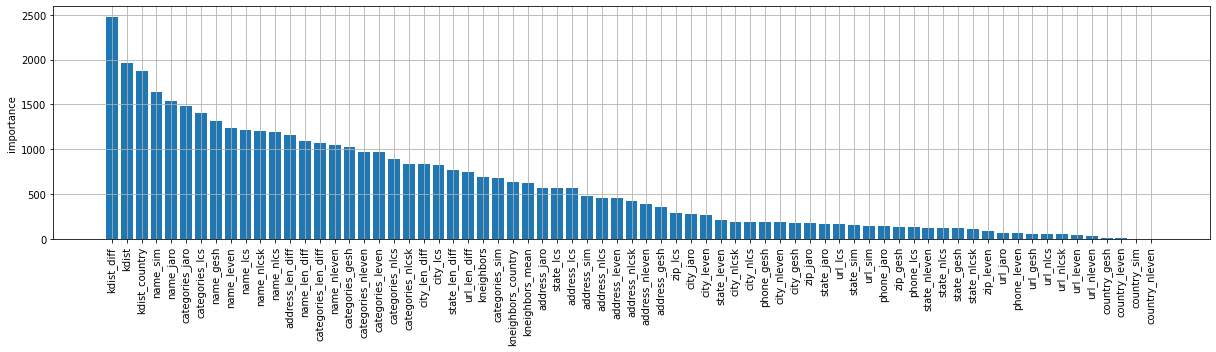

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 210 kB 50.2 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 112 kB 58.6 MB/s 
     |████████████████████████████████| 146 kB 68.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8f9d82c68c3e1d38e876ad82a80ce4146dea377a543886f430d5d8174c7d8fad
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-20 00:06:55,531] A new study created in memory with name: no-name-8d9ef14e-74d3-4ca4-bb82-49c7b0f10675


CV: 0.810211


[I 2022-05-20 00:07:17,958] Trial 0 finished with value: 0.8102110062788581 and parameters: {'threshold': 0.8729267417773345}. Best is trial 0 with value: 0.8102110062788581.
[I 2022-05-20 00:07:41,833] Trial 1 finished with value: 0.7930735695825426 and parameters: {'threshold': 0.17495646194468484}. Best is trial 0 with value: 0.8102110062788581.


CV: 0.793074


[I 2022-05-20 00:08:03,115] Trial 2 finished with value: 0.7451595019116897 and parameters: {'threshold': 0.0820598794123637}. Best is trial 0 with value: 0.8102110062788581.


CV: 0.745160


[I 2022-05-20 00:08:23,238] Trial 3 finished with value: 0.820707104744345 and parameters: {'threshold': 0.8227123783159443}. Best is trial 3 with value: 0.820707104744345.


CV: 0.820707


[I 2022-05-20 00:08:43,630] Trial 4 finished with value: 0.8352163814341452 and parameters: {'threshold': 0.500898150554645}. Best is trial 4 with value: 0.8352163814341452.


CV: 0.835216


[I 2022-05-20 00:09:03,275] Trial 5 finished with value: 0.8088445694151135 and parameters: {'threshold': 0.8781447457417593}. Best is trial 4 with value: 0.8352163814341452.


CV: 0.808845


[I 2022-05-20 00:09:23,104] Trial 6 finished with value: 0.8308979660402878 and parameters: {'threshold': 0.4118374047142134}. Best is trial 4 with value: 0.8352163814341452.


CV: 0.830898


[I 2022-05-20 00:09:45,960] Trial 7 finished with value: 0.6850953262510654 and parameters: {'threshold': 0.03827766333997851}. Best is trial 4 with value: 0.8352163814341452.


CV: 0.685095


[I 2022-05-20 00:10:06,920] Trial 8 finished with value: 0.814458794864154 and parameters: {'threshold': 0.2651034109354471}. Best is trial 4 with value: 0.8352163814341452.


CV: 0.814459


[I 2022-05-20 00:10:28,351] Trial 9 finished with value: 0.7768537417666949 and parameters: {'threshold': 0.13304646261612196}. Best is trial 4 with value: 0.8352163814341452.


CV: 0.776854


[I 2022-05-20 00:10:47,705] Trial 10 finished with value: 0.8364433981910309 and parameters: {'threshold': 0.5942674815991899}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.836443


[I 2022-05-20 00:11:07,084] Trial 11 finished with value: 0.8362267597350586 and parameters: {'threshold': 0.6087256947343761}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.836227


[I 2022-05-20 00:11:27,321] Trial 12 finished with value: 0.8362340472370347 and parameters: {'threshold': 0.6082250448018053}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.836234


[I 2022-05-20 00:11:46,577] Trial 13 finished with value: 0.8345347237165345 and parameters: {'threshold': 0.6727560239334565}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.834535


[I 2022-05-20 00:12:05,759] Trial 14 finished with value: 0.8317930340325248 and parameters: {'threshold': 0.7222423186884994}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.831793


[I 2022-05-20 00:12:27,770] Trial 15 finished with value: 0.8321032624208096 and parameters: {'threshold': 0.4313883489301854}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.832103


[I 2022-05-20 00:12:47,354] Trial 16 finished with value: 0.8350633770583696 and parameters: {'threshold': 0.49378435195108156}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.835063


[I 2022-05-20 00:13:06,417] Trial 17 finished with value: 0.7619895267727593 and parameters: {'threshold': 0.964247939606161}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.761990


[I 2022-05-20 00:13:27,142] Trial 18 finished with value: 0.8181079248824962 and parameters: {'threshold': 0.28757070812081986}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.818108


[I 2022-05-20 00:13:47,383] Trial 19 finished with value: 0.8363859659542063 and parameters: {'threshold': 0.5714120557524317}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.836386


[I 2022-05-20 00:14:06,458] Trial 20 finished with value: 0.8290647315557994 and parameters: {'threshold': 0.7563064279145926}. Best is trial 10 with value: 0.8364433981910309.


CV: 0.829065


[I 2022-05-20 00:14:25,817] Trial 21 finished with value: 0.8364456399045398 and parameters: {'threshold': 0.5960137111903852}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836446


[I 2022-05-20 00:14:46,051] Trial 22 finished with value: 0.8364347275707779 and parameters: {'threshold': 0.5773418247995387}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836435


[I 2022-05-20 00:15:06,081] Trial 23 finished with value: 0.8254522815636276 and parameters: {'threshold': 0.34802158982203646}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.825452


[I 2022-05-20 00:15:25,560] Trial 24 finished with value: 0.835932023962063 and parameters: {'threshold': 0.5350130919483277}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835932


[I 2022-05-20 00:15:45,577] Trial 25 finished with value: 0.8339565054547814 and parameters: {'threshold': 0.6846824745211444}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.833957


[I 2022-05-20 00:16:06,091] Trial 26 finished with value: 0.8329625031036167 and parameters: {'threshold': 0.44750098790205894}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.832963


[I 2022-05-20 00:16:25,603] Trial 27 finished with value: 0.8282119828845743 and parameters: {'threshold': 0.7650327086836661}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.828212


[I 2022-05-20 00:16:44,908] Trial 28 finished with value: 0.8356391949600566 and parameters: {'threshold': 0.6411881874790872}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835639


[I 2022-05-20 00:17:04,651] Trial 29 finished with value: 0.8169621243307881 and parameters: {'threshold': 0.843713016421075}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.816962


[I 2022-05-20 00:17:24,096] Trial 30 finished with value: 0.8361939914857054 and parameters: {'threshold': 0.547825625769446}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836194


[I 2022-05-20 00:17:44,392] Trial 31 finished with value: 0.8363518813108166 and parameters: {'threshold': 0.5599727219991024}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836352


[I 2022-05-20 00:18:03,826] Trial 32 finished with value: 0.8364190670778209 and parameters: {'threshold': 0.5906450451127775}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836419


[I 2022-05-20 00:18:23,667] Trial 33 finished with value: 0.8279884384592091 and parameters: {'threshold': 0.3732112865439896}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.827988


[I 2022-05-20 00:18:44,004] Trial 34 finished with value: 0.8357066361404373 and parameters: {'threshold': 0.6355465583167822}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835707


[I 2022-05-20 00:19:03,939] Trial 35 finished with value: 0.8350132416981747 and parameters: {'threshold': 0.49245218862682105}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835013


[I 2022-05-20 00:19:23,245] Trial 36 finished with value: 0.8289900712478434 and parameters: {'threshold': 0.757220076560187}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.828990


[I 2022-05-20 00:19:43,203] Trial 37 finished with value: 0.8335920223054557 and parameters: {'threshold': 0.6929184956814656}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.833592


[I 2022-05-20 00:20:02,916] Trial 38 finished with value: 0.8017664317587961 and parameters: {'threshold': 0.8997633559918417}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.801766


[I 2022-05-20 00:20:22,700] Trial 39 finished with value: 0.8340603688033628 and parameters: {'threshold': 0.47094573766193737}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.834060


[I 2022-05-20 00:20:42,297] Trial 40 finished with value: 0.836436729117966 and parameters: {'threshold': 0.587602129623794}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836437


[I 2022-05-20 00:21:02,991] Trial 41 finished with value: 0.8363960381120852 and parameters: {'threshold': 0.5720064470106617}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836396


[I 2022-05-20 00:21:23,062] Trial 42 finished with value: 0.8357528360199544 and parameters: {'threshold': 0.6339279899635859}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835753


[I 2022-05-20 00:21:43,762] Trial 43 finished with value: 0.8357418328615243 and parameters: {'threshold': 0.5237984477075883}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835742


[I 2022-05-20 00:22:04,638] Trial 44 finished with value: 0.8364353834844923 and parameters: {'threshold': 0.5845400687978729}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836435


[I 2022-05-20 00:22:25,912] Trial 45 finished with value: 0.8294472128485826 and parameters: {'threshold': 0.38985744435695713}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.829447


[I 2022-05-20 00:22:45,411] Trial 46 finished with value: 0.8320579604235188 and parameters: {'threshold': 0.7185620891256422}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.832058


[I 2022-05-20 00:23:05,354] Trial 47 finished with value: 0.8351236118395367 and parameters: {'threshold': 0.6558460421823477}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.835124


[I 2022-05-20 00:23:25,452] Trial 48 finished with value: 0.824580332230543 and parameters: {'threshold': 0.796603897306214}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.824580


[I 2022-05-20 00:23:45,651] Trial 49 finished with value: 0.8212405808795117 and parameters: {'threshold': 0.31157293032784733}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.821241


[I 2022-05-20 00:24:06,218] Trial 50 finished with value: 0.8363431196428512 and parameters: {'threshold': 0.6022749825556247}. Best is trial 21 with value: 0.8364456399045398.


CV: 0.836343


[I 2022-05-20 00:24:25,745] Trial 51 finished with value: 0.8364511919729943 and parameters: {'threshold': 0.5958877920383803}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836451


[I 2022-05-20 00:24:45,477] Trial 52 finished with value: 0.8357833198419196 and parameters: {'threshold': 0.5270749744947688}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835783


[I 2022-05-20 00:25:06,213] Trial 53 finished with value: 0.8344549907969814 and parameters: {'threshold': 0.479724089929588}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.834455


[I 2022-05-20 00:25:25,721] Trial 54 finished with value: 0.8332202418765459 and parameters: {'threshold': 0.6981375820583475}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.833220


[I 2022-05-20 00:25:45,152] Trial 55 finished with value: 0.8361042519073248 and parameters: {'threshold': 0.61459282451976}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836104


[I 2022-05-20 00:26:05,745] Trial 56 finished with value: 0.832643920481875 and parameters: {'threshold': 0.44218097424852876}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.832644


[I 2022-05-20 00:26:26,285] Trial 57 finished with value: 0.7968760155462028 and parameters: {'threshold': 0.1873043242187713}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.796876


[I 2022-05-20 00:26:46,518] Trial 58 finished with value: 0.8364359965473557 and parameters: {'threshold': 0.5703415067535559}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836436


[I 2022-05-20 00:27:06,990] Trial 59 finished with value: 0.8355846776284653 and parameters: {'threshold': 0.5147288017754849}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835585


[I 2022-05-20 00:27:26,362] Trial 60 finished with value: 0.835151727762627 and parameters: {'threshold': 0.6555385681410588}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835152


[I 2022-05-20 00:27:46,722] Trial 61 finished with value: 0.8363834962038965 and parameters: {'threshold': 0.5636770319857388}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836383


[I 2022-05-20 00:28:06,161] Trial 62 finished with value: 0.8364212988896027 and parameters: {'threshold': 0.5921777957601123}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836421


[I 2022-05-20 00:28:26,116] Trial 63 finished with value: 0.8316075175247337 and parameters: {'threshold': 0.7244027062337962}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.831608


[I 2022-05-20 00:28:46,351] Trial 64 finished with value: 0.836156515905849 and parameters: {'threshold': 0.6123590518141525}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836157


[I 2022-05-20 00:29:06,048] Trial 65 finished with value: 0.8336075609576802 and parameters: {'threshold': 0.4618166398242973}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.833608


[I 2022-05-20 00:29:26,514] Trial 66 finished with value: 0.8310589311312725 and parameters: {'threshold': 0.4148446394354323}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.831059


[I 2022-05-20 00:29:46,747] Trial 67 finished with value: 0.8362692646442358 and parameters: {'threshold': 0.554526346478833}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836269


[I 2022-05-20 00:30:07,228] Trial 68 finished with value: 0.8364505509693331 and parameters: {'threshold': 0.579732208655126}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836451


[I 2022-05-20 00:30:26,557] Trial 69 finished with value: 0.8347565247130445 and parameters: {'threshold': 0.6662977400423788}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.834757


[I 2022-05-20 00:30:46,042] Trial 70 finished with value: 0.8353524927246169 and parameters: {'threshold': 0.5055398101815767}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835352


[I 2022-05-20 00:31:06,281] Trial 71 finished with value: 0.8364307812833598 and parameters: {'threshold': 0.5876491739850196}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836431


[I 2022-05-20 00:31:25,648] Trial 72 finished with value: 0.8357934891469717 and parameters: {'threshold': 0.6317623064955035}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835793


[I 2022-05-20 00:31:46,265] Trial 73 finished with value: 0.8358186521041998 and parameters: {'threshold': 0.5286149256070841}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835819


[I 2022-05-20 00:32:06,825] Trial 74 finished with value: 0.8361757553356081 and parameters: {'threshold': 0.5470099501820203}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836176


[I 2022-05-20 00:32:27,220] Trial 75 finished with value: 0.8364462180904545 and parameters: {'threshold': 0.5791037264052591}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836446


[I 2022-05-20 00:32:46,721] Trial 76 finished with value: 0.8341614495650859 and parameters: {'threshold': 0.6802120565797177}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.834161


[I 2022-05-20 00:33:06,085] Trial 77 finished with value: 0.8359741720999663 and parameters: {'threshold': 0.6218490660917791}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835974


[I 2022-05-20 00:33:29,557] Trial 78 finished with value: 0.6584213755601104 and parameters: {'threshold': 0.028759963156021917}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.658421


[I 2022-05-20 00:33:49,289] Trial 79 finished with value: 0.8351227474321861 and parameters: {'threshold': 0.49631877516859657}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835123


[I 2022-05-20 00:34:09,677] Trial 80 finished with value: 0.8364394779514405 and parameters: {'threshold': 0.5702408228316315}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836439


[I 2022-05-20 00:34:30,029] Trial 81 finished with value: 0.836445115200003 and parameters: {'threshold': 0.5796454871701779}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836445


[I 2022-05-20 00:34:50,475] Trial 82 finished with value: 0.8361765535360213 and parameters: {'threshold': 0.5473633249729989}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836177


[I 2022-05-20 00:35:10,129] Trial 83 finished with value: 0.8364009206914412 and parameters: {'threshold': 0.572200997081565}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836401


[I 2022-05-20 00:35:29,510] Trial 84 finished with value: 0.8352327545825494 and parameters: {'threshold': 0.6530495792734802}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835233


[I 2022-05-20 00:35:49,886] Trial 85 finished with value: 0.83633805838043 and parameters: {'threshold': 0.6034599070143405}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.836338


[I 2022-05-20 00:36:09,205] Trial 86 finished with value: 0.8331732324378298 and parameters: {'threshold': 0.6989047870914883}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.833173


[I 2022-05-20 00:36:29,516] Trial 87 finished with value: 0.8355560448490217 and parameters: {'threshold': 0.5130645068471544}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835556


[I 2022-05-20 00:36:49,860] Trial 88 finished with value: 0.8358293246403803 and parameters: {'threshold': 0.6301302580523148}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.835829


[I 2022-05-20 00:37:09,395] Trial 89 finished with value: 0.8341920620188576 and parameters: {'threshold': 0.47386779651949557}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.834192


[I 2022-05-20 00:37:29,297] Trial 90 finished with value: 0.8314702323120454 and parameters: {'threshold': 0.726140256196188}. Best is trial 51 with value: 0.8364511919729943.


CV: 0.831470


[I 2022-05-20 00:37:49,531] Trial 91 finished with value: 0.8364519996753472 and parameters: {'threshold': 0.5809913015707044}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.836452


[I 2022-05-20 00:38:08,884] Trial 92 finished with value: 0.8364215720763224 and parameters: {'threshold': 0.5740010794777946}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.836422


[I 2022-05-20 00:38:28,985] Trial 93 finished with value: 0.8359517835658279 and parameters: {'threshold': 0.536457890289564}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.835952


[I 2022-05-20 00:38:48,362] Trial 94 finished with value: 0.8364234625214464 and parameters: {'threshold': 0.5979032978865716}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.836423


[I 2022-05-20 00:39:08,611] Trial 95 finished with value: 0.8363698730013958 and parameters: {'threshold': 0.5606266292502304}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.836370


[I 2022-05-20 00:39:28,633] Trial 96 finished with value: 0.8355964590596059 and parameters: {'threshold': 0.6434896468065224}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.835596


[I 2022-05-20 00:39:47,922] Trial 97 finished with value: 0.8360316242254939 and parameters: {'threshold': 0.6192029046716769}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.836032


[I 2022-05-20 00:40:07,848] Trial 98 finished with value: 0.8345632935645809 and parameters: {'threshold': 0.6718813211199897}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.834563


[I 2022-05-20 00:40:27,980] Trial 99 finished with value: 0.8364180084748051 and parameters: {'threshold': 0.5895369091861825}. Best is trial 91 with value: 0.8364519996753472.


CV: 0.836418


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5809913015707044

In [ ]:
study.best_value

0.8364519996753472

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.836452
